<a href="https://colab.research.google.com/github/AdityaPunetha/TensorFlow-Fashion-MNIST-GAN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Flatten,
    Reshape,
    LeakyReLU,
    Dropout,
    UpSampling2D,
    ReLU,
)
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf

# Load Data

In [3]:
ds = tfds.load("fashion_mnist", split="train")

In [4]:
dataiterator = ds.as_numpy_iterator()

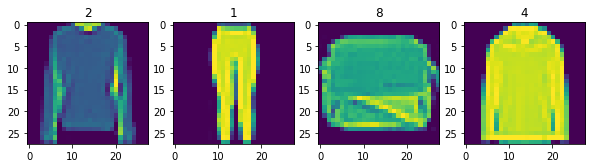

In [5]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample["image"]))
    # Appending the image label as the plot title
    ax[idx].title.set_text(sample["label"])

In [6]:
def scale_images(data):
    image = data["image"]
    image = image / 255
    return (image * 2) - 1

In [7]:
batch_size = 200

In [8]:
# Reload the dataset
ds = tfds.load("fashion_mnist", split="train")
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(batch_size)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

# Generator

In [9]:
latent_size = 128

In [23]:
generator = Sequential()

generator.add(Dense(7 * 7 * 128, input_dim=latent_size))
generator.add(ReLU())
generator.add(Reshape((7, 7, 128)))

# Upsampling block 1
generator.add(UpSampling2D())
generator.add(Conv2D(128, 5, padding="same"))
generator.add(ReLU())

# Upsampling block 2
generator.add(UpSampling2D())
generator.add(Conv2D(128, 5, padding="same"))
generator.add(ReLU())

# Convolutional block 1
generator.add(Conv2D(128, 4, padding="same"))
generator.add(ReLU())

# Convolutional block 2
generator.add(Conv2D(128, 4, padding="same"))
generator.add(ReLU())

# Conv layer to get to one channel
generator.add(Conv2D(1, 4, padding="same", activation="tanh"))

In [11]:
img = generator.predict(np.random.randn(1, 128, 1))

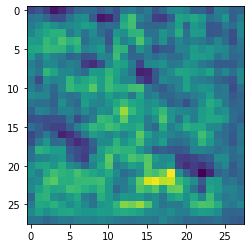

In [12]:
plt.imshow(np.squeeze(img[0]))

# Build Discriminator

In [24]:
discriminator = Sequential()

# First Conv Block
discriminator.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))

# Second Conv Block
discriminator.add(Conv2D(64, 5))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))

# Third Conv Block
discriminator.add(Conv2D(128, 5))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))

# Fourth Conv Block
discriminator.add(Conv2D(256, 5))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))

# Flatten then pass to dense layer
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation="sigmoid"))

In [14]:
discriminator.predict(img)

array([[0.4993011]], dtype=float32)

# Construct Training Loop

In [22]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [26]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(
            tf.random.normal((batch_size, 128, 1)), training=False
        )

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat(
                [tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0
            )

            # Add some noise to the TRUE outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(
                tf.zeros_like(predicted_labels), predicted_labels
            )

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [27]:
fashgan = FashionGAN(generator, discriminator)

In [28]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

# Build Callback

In [19]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join("images", f"generated_img_{epoch}_{i}.png"))

# Train

In [20]:
!nvidia-smi

Mon Jun 13 16:31:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |   1130MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/300 [..............................] - ETA: 57s - d_loss: 0.6903 - g_loss: 0.6857WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0941s vs `on_train_batch_end` time: 0.1047s). Check your callbacks.


300/300 [==============================] - 61s 199ms/step - d_loss: 0.3805 - g_loss: 3.4095
